## Using Machine Learning to Predict NBA Awards

#### Declare Libraries

In [113]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.feature_selection import RFECV, RFE

#### Read in the CSV Files using Pandas

In [114]:
# read in the main csv file
nba_df = pd.read_csv("csv_files/nba_data.csv")

# read in the 2024 csv file
nba_2024_df = pd.read_csv("csv_files/2024_nba_data.csv")

# read in the rookies file
rookies_df = pd.read_csv("csv_files/2024_nba_rookies.csv")

# make the rookies into a list
rookies = list(rookies_df['Player'])

##### A Quick Disclaimer

In [115]:
# the nba has implemented new rules that you must play at least 65 games in the season to be eligible for nba awards
# I will be taking these notable players out of the dataframe
ineligible_players = ['Zach LaVine', 'Ja Morant', 'Joel Embiid', 'Bradley Beal', 'Evan Mobley',
                      'Darius Garland', 'Khris Middleton', 'O.G. Anunoby', 'Kyrie Irving', 
                      'Kristaps Porzingis',	'Julius Randle', 'Jimmy Butler', 'Donovan Mitchell']

# filter out the ineligible players
nba_2024_df = nba_2024_df[~nba_2024_df['player'].isin(ineligible_players)]

# create a copy to use later
nba_2024_copy = nba_2024_df.copy()

##### Prepare Machine Learning By Doing Feature Selection

- We are going to use a random forest regressor to determine the best features for predicting each award
- First, determine which features are the best for each award

In [116]:
def get_selected_columns(award_name, historic_nba_dataframe):
    """
    :param award_name: a specific award name
    :param historic_nba_dataframe: the dataframe containing nba data from previous seasons
    :return: the preferred selected columns
    """
    
    # initial feature columns
    x_columns = [column for column in historic_nba_dataframe.columns if not('share' in column)]
    y_columns = [column for column in historic_nba_dataframe.columns if award_name in column]

    # temporarily remove player, pos, tm, and Unnamed columns from the dataframe 
    x_columns.remove('player')
    x_columns.remove('pos')
    x_columns.remove('tm')
    
    # first split the previous nba data into training sets
    temp_x_train = historic_nba_dataframe[x_columns]
    temp_y_train = historic_nba_dataframe[y_columns]
    
    # change or reshape y to avoid error
    temp_y_train = np.ravel(temp_y_train)

    # initialize random forest regressor
    rf_regressor = RandomForestRegressor(random_state=40)

    """
    I initially ran the rfecv to get the most optimal features for each award.
    I have the optimized features for each award written down, but if you really wanted to rerun it, it takes 6 hours.
    The rfecv goes through and finds the most optimal number of features for feature selection based on cv accuracy.
    You can also run the rfe for a select number of features, and it is far quicker because it doesn't check every
    number of features value.
    
    Here are the lines for the rfe:
    rfe = RFE(estimator=rf_regressor, step=1, n_features_to_select=15)

    # fit the rfe
    rfe.fit(temp_x_train, temp_y_train)
    
    # get back the best selected columns
    rfe_selected_features = temp_x_train.columns[rfe.support_]
        
    return rfe_selected_features
    """
    
    # initialize the RFECV (Recursive Feature Elimination Cross Validation)
    rfecv = RFECV(estimator=rf_regressor, step=1, min_features_to_select=15)

    # fit the rfecv
    rfecv.fit(temp_x_train, temp_y_train)
    
    # get back the best selected columns
    rfecv_selected_features = temp_x_train.columns[rfecv.support_]
        
    return rfecv_selected_features

In [117]:
# create an award list
award_list = ["all_mvp", "all_roy", "all_dpoy", "all_smoy", "all_mip",
                  "all_nba", "all_defense"]

# a dictionary which holds the important selected features for each award
award_features_dict = {}

In [ ]:
# loop through awards, getting the select features for each award prediction
# due to the immense amount of time for obtaining the selected features,
# we will perform only this task in the loop
for award in award_list:
    selected_columns = get_selected_columns(award, nba_df)
    award_features_dict.update({award: selected_columns})

In [118]:
# the award feature dictionary I got after running RFECV took six hours to run.
# I initially wrote it down, so I didn't have to deal with the issue of rerunning everytime.
# I also tinkered with the feature selection myself, seeing how I could optimize the accuracy even further.
# After hours of testing, here is the feature selection dictionary which the computer and I deem optimal.
award_features_dict = {
    'all_mvp': ['mp', 'pts', 'ast', 'tov', 'fg', '2p', '2pa', 'fta', 'ft%',
        'efg', 'on-off', 'drtg', 'per', 'usg%', 'dws', 'ws', 'vorp', 'team_seed', 'win_percentage'],
    'all_roy': ['age', 'g', 'gs', 'mp', 'pts', 'trb', 'ast', 'fg', 'ft%',
        'on-off', 'tov%', 'ows', 'dws', 'team_seed', 'win_percentage'],
    'all_dpoy': ['g', 'mp', 'orb', 'trb', 'stl', 'blk', 'pf', 'fg%', 'ts',
                 'on-off', 'per', 'drb%', 'blk%', 'tov%',
                 'usg%', 'dws', 'ws', 'dbpm', 'win_percentage'],
    'all_smoy': ['g', 'gs', 'mp', 'pts', 'fg', 'fga', 'ftr', 'ast%', 'ws', 'vorp',
        'win_percentage'],
    'all_mip': ['age', 'g', 'gs', 'mp', 'pts', 'trb', '3p%', '2p', '2pa', '2p%', 'ft%',
        'ts', 'ftr', '3par+', 'on-off', 'orb%', 'drb%', 'ast%', 'stl%', 'blk%',
        'tov%', 'usg%', 'ows', 'dws', 'ws', 'ws/48', 'dbpm', 'vorp',
        'win_percentage', 'year'],
    'all_nba': ['pts', 'trb', 'ast', 'fg', 'fga', '2p', '2pa', 'fta', 'ft%', '3p+',
        'on-off', 'drtg', 'per', 'orb%', 'usg%', 'dws', 'ws', 'vorp',
        'team_seed', 'win_percentage'],
    'all_defense': ['g', 'mp', 'ast', 'stl', '2p%', 'on-off', 'per', 'drb%', 'blk%', 'dws',
        'ws', 'dbpm', 'win_percentage'],
    }

##### Predict NBA Award Voting Rankings Using The Feature Selections

- We can first analyze the model itself by looking at the feature importance markup for each award
- Then, we will predict the voting ranking for each award
- Most Improved Player and Rookie of the Year have special exceptions, so we will have to create special functions for those
- I'll do my best to create nice visualizations

In [119]:
def analyze_feature_importance(award_name, preferred_columns, preferred_column_importance, c):
    """
    :param award_name: a specific award name
    :param preferred_columns: the preferred selected columns of the award name
    :param preferred_column_importance: the importance values of those selected columns
    :param c: the counter variable of the current spot on the subplot
    :return: null (plotting)
    """
    
    # edit the award name for the plot (i.e. make it look nicer)
    award_name = award_name.replace("_", " ").title()
    
    # I am going to make pie charts for each award, identifying the most important features for each
    plt.subplot(2, 4, c + 1)
    plt.pie(preferred_column_importance, labels=preferred_columns,
            autopct='%1.1f%%', startangle=140, textprops={'fontsize': 7.5})
    
    # adjust the label font size
    plt.setp(plt.gca().get_xticklabels(), fontsize=10)
    
    # additional plot adjustments
    plt.title(f"{award_name} Voting Feature Importance", fontsize=13)
    plt.axis('equal') 

In [120]:
def predict_award(award_name, x_train_set, y_train_set, x_test_set, pred_performance_dict, feature_importance):
    """
    :param award_name: a specific award name
    :param x_train_set: the x columns training set for the random forest regression
    :param y_train_set: the y columns training set for the random forest regression
    :param x_test_set: the x columns test set for the random forest regression
    :param pred_performance_dict: a dictionary holding the important evaluation metrics for the prediction of each award
    :param feature_importance: a dictionary holding the feature importance values for each award
    :return: predicted award rankings
    """
    
    # initialize random forest regressor
    rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)

    # train the model
    rf_regressor.fit(x_train_set, y_train_set)

    # predict award rankings for training set
    y_train_pred_set = rf_regressor.predict(x_train_set)
        
    # calculate mean absolute error and the R^2 score on training set and add to the dictionary
    mae = mean_absolute_error(y_train_set, y_train_pred_set)
    r2 = r2_score(y_train_set, y_train_pred_set)
    temp_dict = {'mae': mae, 'r2': r2}
    pred_performance_dict.update({award_name: temp_dict})
    
    # calculate feature importance values on training set and add to the feature_importance dictionary
    feature_importance.update({award_name: rf_regressor.feature_importances_})
    
    # now actually predict the awards for the test set (the dataframe from this season)
    y_pred_2024_set = rf_regressor.predict(x_test_set)
    
    return y_pred_2024_set

In [121]:
def fix_roy(roy_voting_list, current_nba_df, rookie_list):
    """
    :param roy_voting_list: the voting list for the Rookie of the Year
    :param current_nba_df: the nba dataframe for the 2024 nba season
    :param rookie_list: a list of the 2024 rookies
    :return: a fixed voting list that contains all the players from the 2024 season
    """

    # add the row voting ranking to the copied dataframe
    current_nba_df['roy_prediction'] = roy_voting_list
        
    # now go through the dataframe and add the roy voting rankings
    for index, row in current_nba_df.iterrows():
        if not (row['player'] in rookie_list):
            current_nba_df.at[index, 'roy_prediction'] = 0.0
    
    # return the altered column roy voting rankings
    return current_nba_df[['roy_prediction']]

In [122]:
def fix_mip(mip_voting_list, current_nba_df, rookie_list):
    """
    :param mip_voting_list: the voting list for the Most Improved Player
    :param current_nba_df: the nba dataframe for the 2024 nba season
    :param rookie_list: a list of the 2024 rookies
    :return: a fixed voting list that contains all the players from the 2024 season
    """
    
    # add the mip voting ranking to the copied dataframe
    current_nba_df['mip_prediction'] = mip_voting_list
        
    # now go through the dataframe and add the mip voting rankings
    for index, row in current_nba_df.iterrows():
        if row['player'] in rookie_list:
            current_nba_df.at[index, 'mip_prediction'] = 0.0
    
    # return the altered column mip voting rankings
    return current_nba_df[['mip_prediction']]

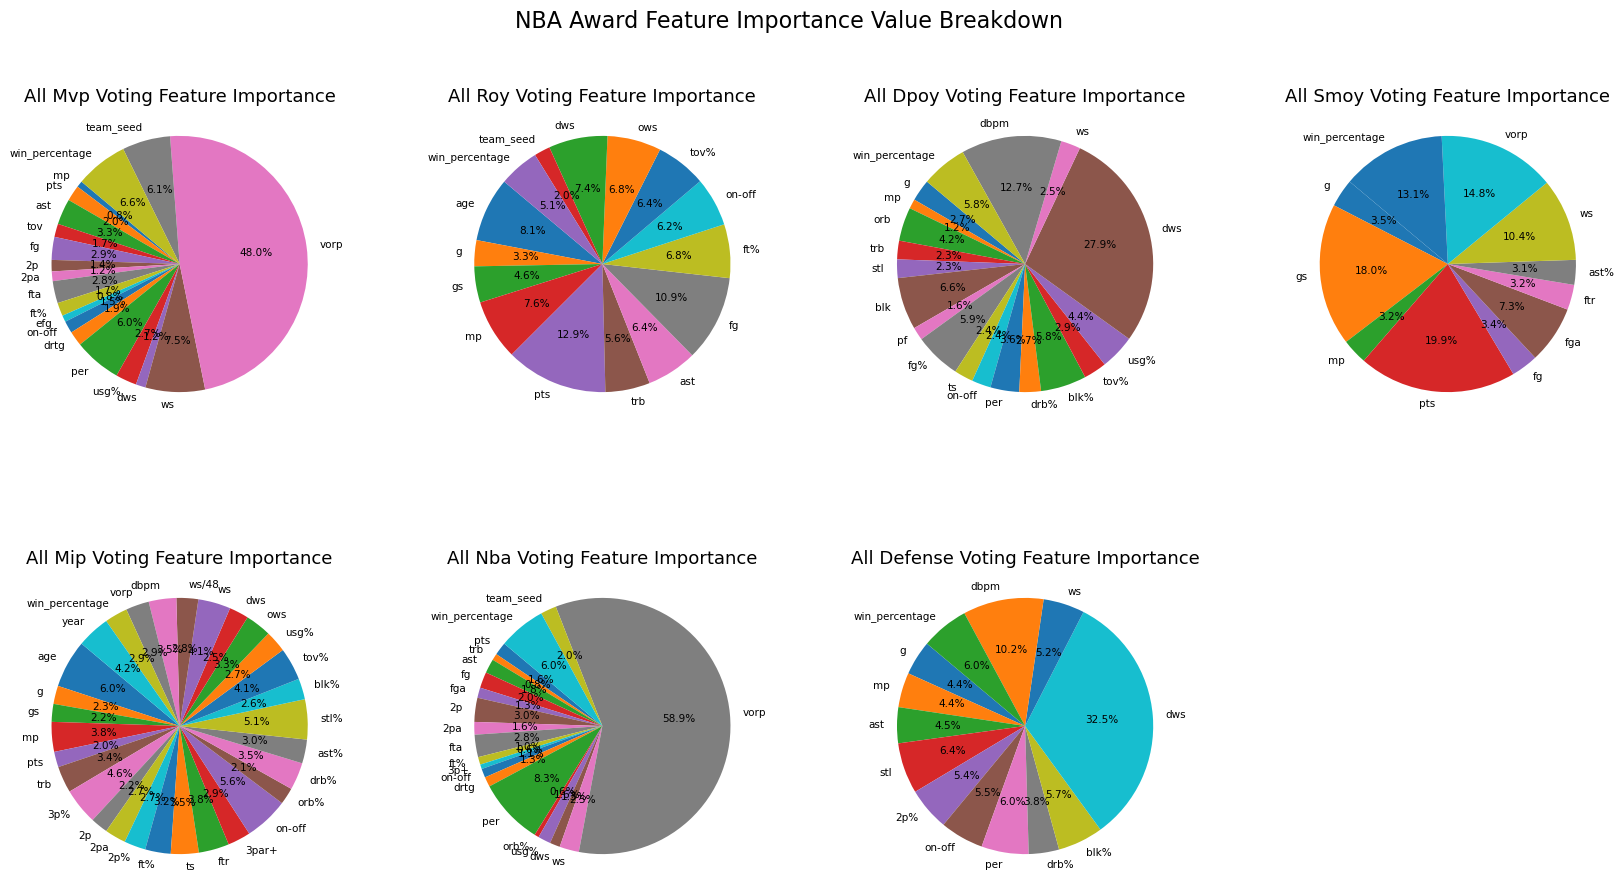

In [123]:
# we will loop through each award, getting back the voting ranking and adding it as a column to the
# current nba dataframe season

# keep track of mean absolute error (regular and percentage), the R^2 score, and feature importance values for each award
award_prediction_scores = {}
award_feature_importance = {}

# we are also going to create a plot which contains all the pie charts
plt.figure(figsize=(20, 10))
plt.subplots_adjust(wspace=0.5, hspace=0.5) 
counter = 0
for award, award_selected_columns in award_features_dict.items():
    
    # create training sets and the test set with the preferred columns
    x_train = nba_df[award_selected_columns]
    y_train = nba_df[f"{award}_share"]
    x_test = nba_2024_df[award_selected_columns]
    
    # get the predicted voting list
    temp_award_voting_list = predict_award(award, x_train, y_train, x_test,
                                           award_prediction_scores, award_feature_importance)
    
    # make special fixes to the Rookie of the Year and Most Improved Player voting rankings
    if award == 'all_roy':
        temp_award_voting_list = fix_roy(temp_award_voting_list, nba_2024_copy, rookies)
    elif award == 'all_mip':
        temp_award_voting_list = fix_mip(temp_award_voting_list, nba_2024_copy, rookies)
    
    # analyze the feature importance values 
    analyze_feature_importance(award, award_selected_columns, award_feature_importance[award], counter)
    
    # add the award prediction to the dataframe
    nba_2024_df[f"{award}_share"] = temp_award_voting_list
    
    # update the counter for the subplot
    counter += 1

# give a name for the entire plot
plt.suptitle('NBA Award Feature Importance Value Breakdown', fontsize=16)
plt.show()

##### Get and Clean Award Evaluation Scores

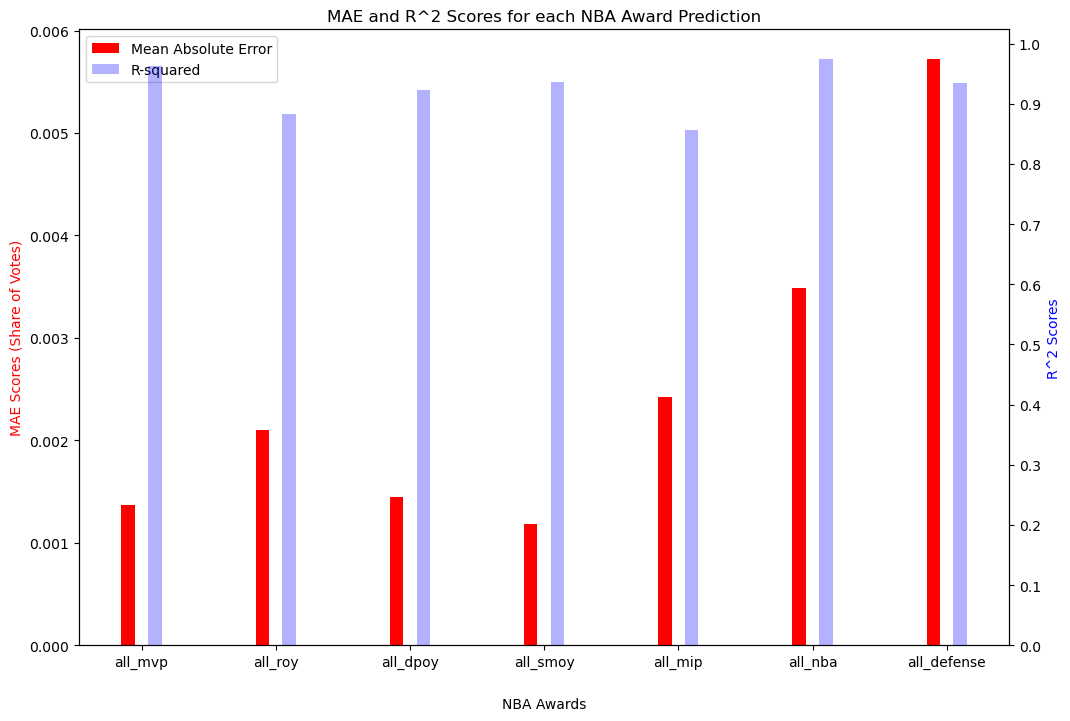

In [124]:
# now let's make a bar graph to look at the mae and r^2 values for each award
# we're going to make a really cool plot

# let's define the names and values; we have the award list from earlier, and get the scores
award_names = award_list
mae_scores = [award_scores['mae'] for award_scores in list(award_prediction_scores.values())]
r2_scores = [award_scores['r2'] for award_scores in list(award_prediction_scores.values())]

# let's make sure the width is fine for each bar
bar_width = 0.1
name_index = np.arange(len(award_names))

# make figure and axes
fig, ax1 = plt.subplots(figsize=(12, 8))

# make bars for MAE on the left y-axis
bar1 = ax1.bar(name_index - bar_width, mae_scores, bar_width, color='r', label='Mean Absolute Error Scores')

# make bar for R-Squared on the right y-axis
ax2 = ax1.twinx()  
bar2 = ax2.bar(name_index + bar_width, r2_scores, bar_width, color='b', label='R-Squared Scores', alpha=0.3)

# create a legend
bars = [bar1[0], bar2[0]]
labels = ['Mean Absolute Error', 'R-squared']

# additional plot adjustments
ax1.set_xlabel('NBA Awards', labelpad=20)
ax1.set_ylabel('MAE Scores (Share of Votes)', color='r')
ax2.set_ylabel('R^2 Scores', color='b')
ax2.set_yticks([i/10 for i in range(11)])
ax1.set_xticks(name_index)
ax1.set_xticklabels(award_names)
ax1.set_title('MAE and R^2 Scores for each NBA Award Prediction')
ax1.legend(bars, labels, loc='upper left')

# show the plot
plt.show()

##### Clean Up the Prediction Values (i.e. Make Them Neater)

In [125]:
def get_prediction_data(award_prediction_dataframe, award_name):
    """
    :param award_prediction_dataframe: a prediction dataframe that contains player names and specific award ranks
    :param award_name: the name of the specific award
    :return: two lists: the players, and their shares 
    """
    
    # turn the columns into lists
    player_names =  award_prediction_dataframe['player'].tolist()
    player_shares = award_prediction_dataframe[f"{award_name}_share"].tolist()
    
    return player_names, player_shares

In [126]:
# specify the ranking dataframes for each award and transform the values to my opinion of a "confidence percentage";
# the closer to 1, the more confident the model was on a player
mvp_prediction = (nba_2024_df[['player', 'all_mvp_share']].sort_values(by="all_mvp_share", ascending=False).head(10))
mvp_names, mvp_confidence = get_prediction_data(mvp_prediction, 'all_mvp')

roy_prediction = nba_2024_df[['player', 'all_roy_share']].sort_values(by="all_roy_share", ascending=False).head(10)
roy_names, roy_confidence = get_prediction_data(roy_prediction, 'all_roy')

dpoy_prediction = nba_2024_df[['player', 'all_dpoy_share']].sort_values(by="all_dpoy_share", ascending=False).head(10)
dpoy_names, dpoy_confidence = get_prediction_data(dpoy_prediction, 'all_dpoy')

smoy_prediction = nba_2024_df[['player', 'all_smoy_share']].sort_values(by="all_smoy_share", ascending=False).head(10)
smoy_names, smoy_confidence = get_prediction_data(smoy_prediction, 'all_smoy')

mip_prediction = nba_2024_df[['player', 'all_mip_share']].sort_values(by="all_mip_share", ascending=False).head(10)
mip_names, mip_confidence = get_prediction_data(mip_prediction, 'all_mip')

all_nba_prediction = nba_2024_df[['player', 'all_nba_share']].sort_values(by="all_nba_share", ascending=False).head(15)
all_nba_names, all_nba_confidence = get_prediction_data(all_nba_prediction, 'all_nba')

all_defense_prediction = nba_2024_df[['player', 'all_defense_share']].sort_values(by="all_defense_share",
                                                                                  ascending=False).head(10)
all_defense_names, all_defense_confidence = get_prediction_data(all_defense_prediction, 'all_defense', )

# converge everything into double linked list
predictions = [['MVP', mvp_names, mvp_confidence], ['ROY', roy_names, roy_confidence],
               ['DPOY', dpoy_names, dpoy_confidence], ['SMOY', smoy_names, smoy_confidence],
               ['MIP', mip_names, mip_confidence], ['All NBA Team', all_nba_names, all_nba_confidence],
               ['All Defense Team', all_defense_names, all_defense_confidence]]

##### Make Subplots to Show Prediction Confidence

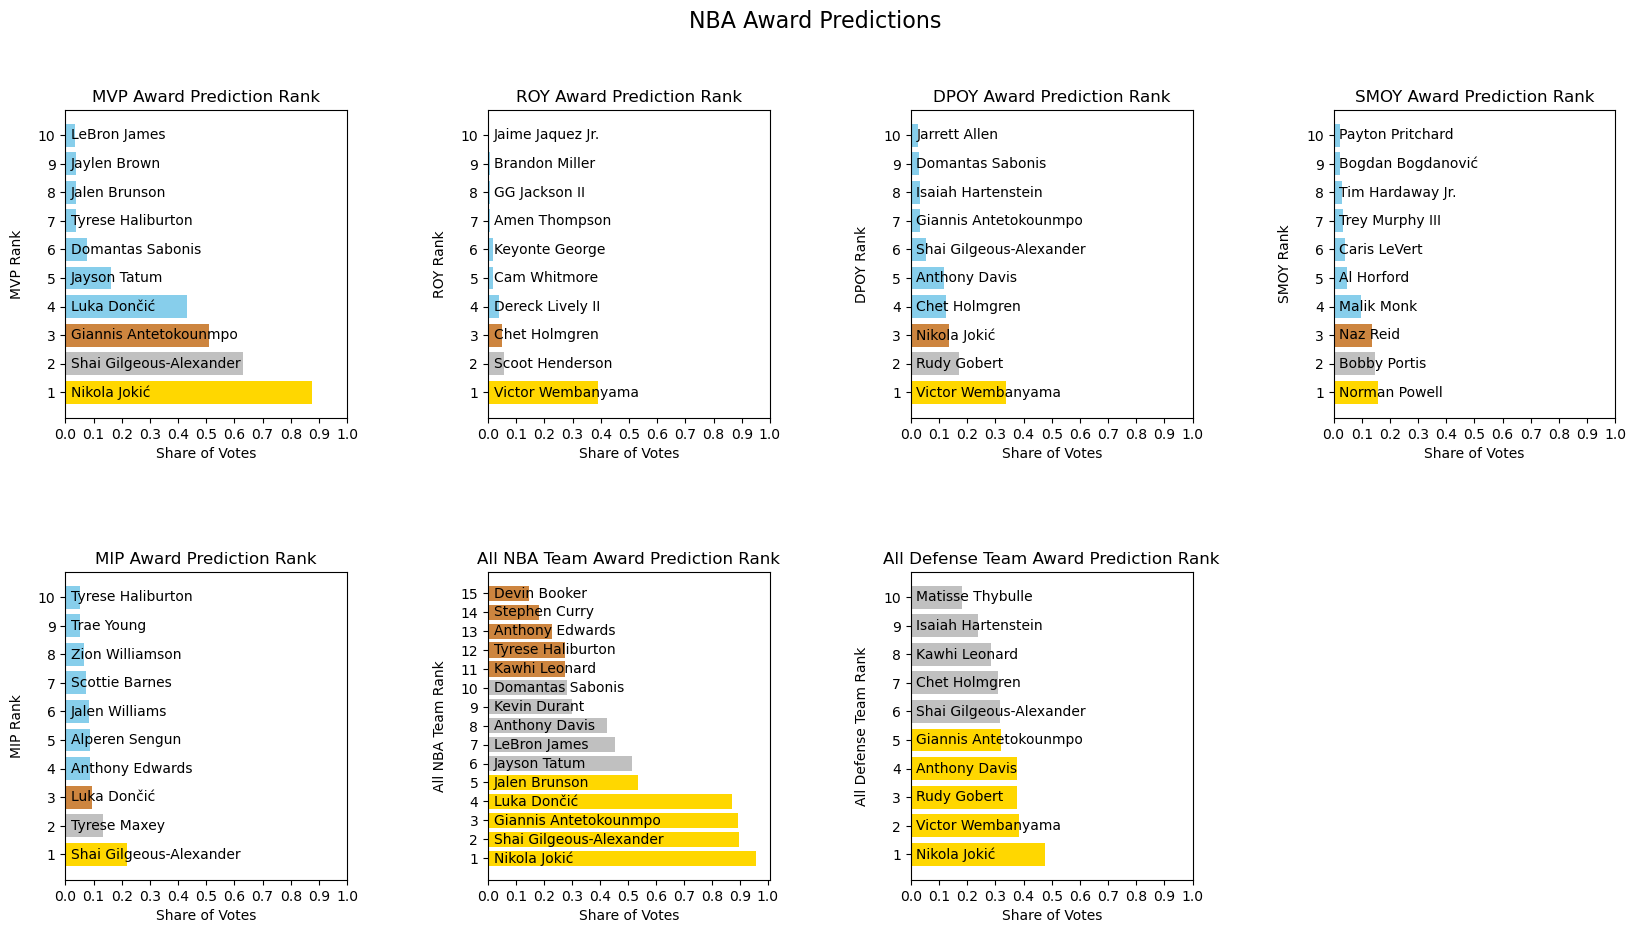

In [127]:
# we're going to make a subplot for each of the awards to display the confidence
plt.figure(figsize=(20, 10))
plt.subplots_adjust(wspace=0.5, hspace=0.5) 

# loop through and add a subplot for each award
for i, award_info in enumerate(predictions):
        
    # specify subplot
    plt.subplot(2, 4, i + 1)
    
    # create colors based on specific conditions
    if award_info[0] == 'All NBA Team':
        colors = ['gold', 'gold', 'gold', 'gold', 'gold',
                  'silver', 'silver', 'silver', 'silver', 'silver',
                  'peru', 'peru', 'peru', 'peru', 'peru']
    elif award_info[0] == 'All Defense Team':
        colors = ['gold' if i < 5 else 'silver' for i in range(10)]
    else:
        colors = [ 'gold',  'silver', 'peru', 'skyblue', 'skyblue', 'skyblue', 'skyblue', 'skyblue', 'skyblue', 'skyblue']
    
    # create the bar graph
    plt.barh(range(1, len(award_info[1]) + 1), width=award_info[2], color=colors)
    
    # add the names inside the bars
    for j, value in enumerate(award_info[2]):
        plt.text(0.02, j+1, award_info[1][j], va='center')
        
    # additional plot adjustments
    plt.ylabel(f"{award_info[0]} Rank", labelpad=10)
    plt.xlabel("Share of Votes", color='black')
    plt.yticks(range(1, len(award_info[1]) + 1))
    plt.xticks([i/10 for i in range(11)])
    plt.title(f"{award_info[0]} Award Prediction Rank")  
    
# name the entire plot
plt.suptitle('NBA Award Predictions', fontsize=16)
plt.show()